### Simulating an Ising Model with Glauber Dynamics


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


### Glauber Dynamics Algorithm
Single iteration:
1. Choose a random site $\sigma$.
2. Sum its four neighboring spins S.
3. Energy $E = 2\sigma S$
4. $\textbf{P}(flip)=\frac{1}{1+e^{E/T}}$ ; T = Temperature

In [ ]:
### Glauber Dynamics Parent Class:
class IsingModel:
    """
    A class for simulating the spin flips in an Ising Model

    Args:
        grid (array): Lattice of particles' spins, -1 = down | +1 = up
        temp (float, opt.): Temperature of the model. Default is 0
        seed (float, opt.): Random seed for simulation, Default is None
        store_history (bool, opt.): Keeps a record of past steps. Default is False.
        Algorithm (str, opt): Glauber or Metropolis

    Attributes:
        history (list, opt.): Record of past grids

    Methods:
        step: Simulate a single step of the process
        run: Simulate the process for a given number of steps
        get_totalenergy: 
    """
    def __init__(self, lattice, temp= 0, seed= None, algorithm= "Glauber", store_history= False):
        np.random.seed(seed)
        self.lattice = np.pad(lattice, pad_width= 1)
        self.temp = temp
        self.algorithm = algorithm
        self.store_history = store_history
        self.history = [self.lattice.copy()]

    def _get_energy(self, r, c):
        """Finds the energy of a site"""
        pass

    def _step(self):
        """Chooses a random lattice site and determines if it flips."""
        r = np.random.randint(1, np.shape(self.lattice)[0] - 1)
        c = np.random.randint(1, np.shape(self.lattice)[1] - 1)

        del_E = self._get_energy(r,c)

        if self.temp != 0:
            if self.algorithm == "Glauber":
                p = 1/(1 + np.e**(del_E/self.temp))
            elif self.algorithm == "Metropolis":
                if del_E > 0:
                    p = np.e ** (-del_E/self.temp)
                else:
                    p = 1
            else:
                return NotImplementedError
        else:
            if del_E < 0:
                p = 1
            else:
                p = 0

        if np.random.rand() < p:
            self.lattice[r][c] *= -1

    def run(self, n_steps):
        """Runs the Ising Model for n_steps"""
        for i in range(n_steps):
            self._step()
            if self.store_history == True and not np.array_equal(self.history[-1],self.lattice):
                self.history.append(self.lattice.copy())

    def get_totalenergy(self):
        """Finds the total energy of the lattice"""
        total_energy = 0
        for r in range(1, np.shape(self.lattice)[0] - 1):
            for c in range(1, np.shape(self.lattice)[1] - 1):
                 total_energy -= self._get_energy(r,c)
        
        return total_energy  

    def plot(self):
        """Plots the lattice. Red = Up | Blue = Down | White = Boundary""" 
        pass


class Square(IsingModel):

    def __init__(self, lattice, temp=0, seed=None, algorithm= "Glauber", store_history= False):
        super().__init__(lattice, temp, seed, algorithm, store_history)

    def _get_energy(self, r, c):
        spin_sum = self.lattice[r+1][c] + self.lattice[r][c+1] + self.lattice[r-1][c] + self.lattice[r][c-1]
        del_E = 2*self.lattice[r][c]*spin_sum
        return del_E

    def plot(self):
        plt.figure()
        plt.imshow(self.lattice, cmap='coolwarm')
        plt.title(f"Temperature:{self.temp}")


class Honeycomb(IsingModel):
    def __init__(self, lattice, temp=0, seed=None, algorithm="Glauber", store_history= False):
        super().__init__(lattice, temp, seed, algorithm, store_history)

    def _get_energy(self, r, c) -> int:
        """Returns the energy of a given site"""
        spin_sum = self.lattice[r][c+1] + self.lattice[r][c-1]
        
        if c-1 % 4 == 0:
            spin_sum += self.lattice[r+1][c+1]
        elif c-2 % 4 == 0:
            spin_sum += self.lattice[r-1][c-1]
        elif c-3 % 4 == 0:
            spin_sum += self.lattice[r-1][c+1]
        elif c % 4 == 0:
            spin_sum += self.lattice[r+1][c-1]

        del_E = 2*self.lattice[r][c]*spin_sum

        return del_E

    def plot(self):
        x = []
        y = []
        z = []
        for r in range(np.shape(self.lattice)[0]):
            x_coord = 0
            for c in range(np.shape(self.lattice)[1]):
                # checks if on column(2,3 , 6,7 , 10,11...) -> vertically displaces
                if (c+1) % 4 == 0 or (c+2) % 4 == 0:
                    y_shift = (np.sqrt(3) / 2)
                else:
                    y_shift = 0

                x.append(x_coord)
                y.append(np.sqrt(3)*r + y_shift)
                z.append(self.lattice[r][c])

                if c % 2 == 0:
                    x_coord += 1
                else:
                    x_coord += 0.5

        plt.figure(figsize=(4, 3))
        sc = plt.scatter(x, y, c=z, cmap='coolwarm', edgecolor='k', s= 100)

        cbar = plt.colorbar(sc)
        cbar.set_label('Spin (color scale)')

        plt.xlabel('X-axis')
        plt.ylabel("Y-axis")
        plt.title('Honeycomb Ising Model')
        plt.axis('equal')
        
        

Test

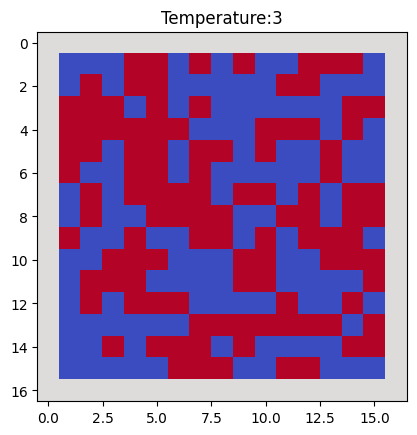

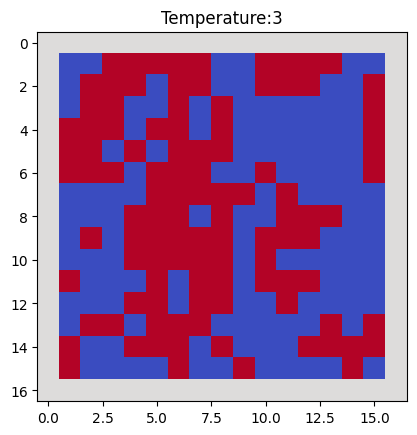

In [40]:
myGrid = np.random.choice((-1,1), size= (15,15))
model = Square(lattice= myGrid, temp = 3)
model.plot()
model.run(1000)
model.plot()

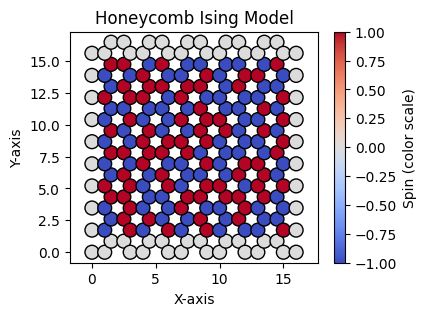

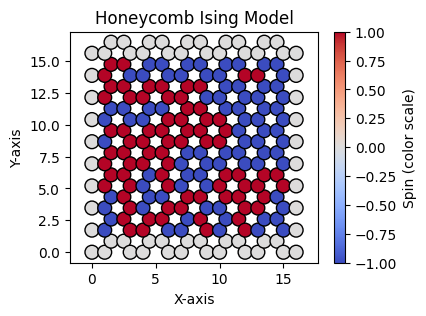

In [39]:
myGrid = np.random.choice((-1,1), size= (8,20))
# myGrid = np.array([-1,-1,-1,-1,-1,-1,1,1,1,1,1,1])[:,None]
model = Honeycomb(lattice= myGrid)
model.plot()
model.run(10000)
model.plot()


Animation

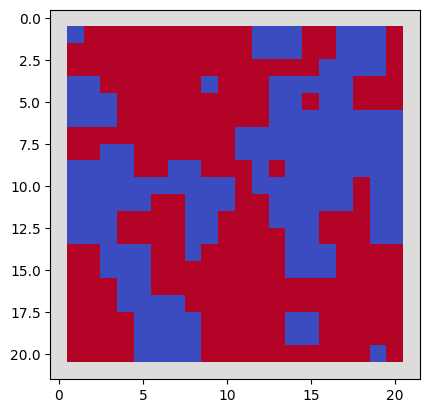

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters for the grid
myGrid = np.random.choice((-1,1), size= (20,20))  # Grid creation
n_steps = 1000         # Number of frames in the animation

#Assign the model using the GlauberDynamics class
model=Square(myGrid, temp= 0, store_history= True, seed= 0)

# Run simulation n times
model.run(n_steps)


# Set up the figure and initial plot
fig, ax = plt.subplots()
im = ax.imshow(model.history[0], cmap='coolwarm', vmin=-1, vmax=1)

# Initialization function: displays the first frame
def init():
    im.set_data(model.history[0])
    return [im]

# Update function: updates the image data for each frame
def update(frame):
    im.set_data(model.history[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=len(model.history), init_func=init, blit=True, interval=50)

HTML(ani.to_jshtml())

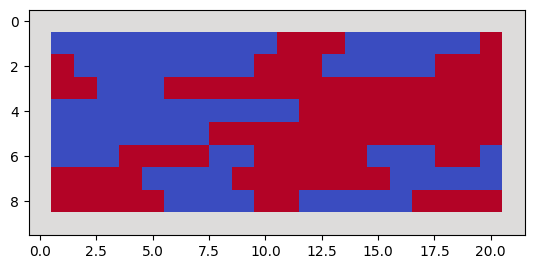

In [41]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters for the grid
myGrid = np.random.choice((-1,1), size= (8,20))  # Grid creation
n_steps = 1000         # Number of frames in the animation

#Assign the model using the GlauberDynamics class
model=Honeycomb(myGrid, temp= 0, store_history= True, seed= 0)

# Run simulation n times
model.run(n_steps)


# Set up the figure and initial plot
fig, ax = plt.subplots()
im = ax.imshow(model.history[0], cmap='coolwarm', vmin=-1, vmax=1)

# Initialization function: displays the first frame
def init():
    im.set_data(model.history[0])
    return [im]

# Update function: updates the image data for each frame
def update(frame):
    im.set_data(model.history[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=len(model.history), init_func=init, blit=True, interval=50)

HTML(ani.to_jshtml())